In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [11]:
# read the annotated dataset
data_df = pd.read_csv("ner_datasetreference.csv", encoding="iso-8859-1", header=0)
data_df.head()


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
#replace zero values with last valid observation

#data_df = data_df.fillna(method="ffill")

#data_df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [33]:
#data_df = data_df.fillna(method="ffill")
#data_df["Sentence #"] = data_df["Sentence #"].apply(lambda s: s[9:])
#data_df["Sentence #"] = data_df["Sentence #"].astype("int32")
#data_df.head()

,Sentence #,Word,POS,Tag
0,1,Thousands,NNS,O
1,1,of,IN,O
2,1,demonstrators,NNS,O
3,1,have,VBP,O
4,1,marched,VBN,O


In [37]:
word_counts = data_df.groupby("Sentence #")["Word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
#word_counts.hist(bins=50, figsize=(8,6));
print(word_counts)

            Word count
Sentence #            
1                   24
2                   30
3                   14
4                   15
5                   25
...                ...
47955               20
47956               24
47957               11
47958               11
47959                8

[47959 rows x 1 columns]


In [38]:
# count number of sentences and number of words

print("Total number of sentences in the dataset:", data_df["Sentence #"].nunique())
print("Total words in the dataset:", (data_df.shape[0]))

Total number of sentences in the dataset: 47959
Total words in the dataset: 1048575


<Axes: >

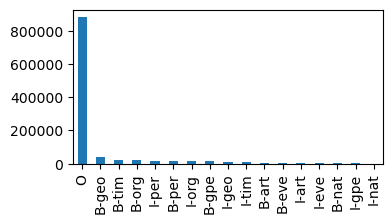

In [45]:
data_df["Tag"].value_counts().plot(kind="bar", figsize=(4,2))

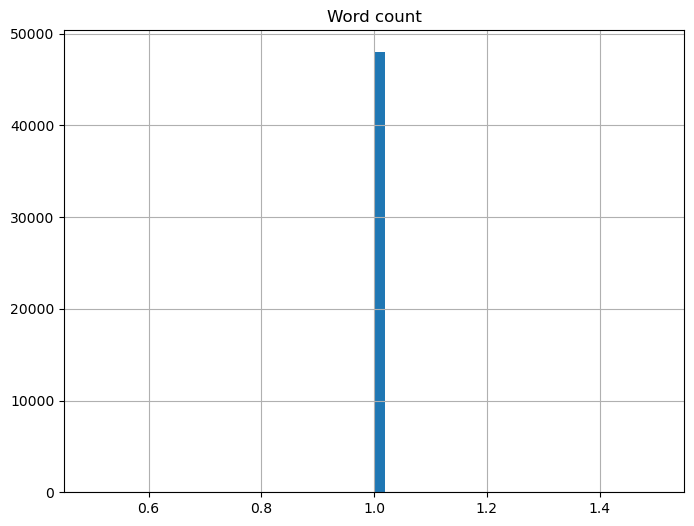

In [32]:
# count labels

#data_df["Tag"].value_counts()
#print(data_df[data_df["Tag"]!="O"]["Tag"].value_counts())
#print(data_df[data_df["Tag"]=="O"]["Tag"].value_counts())

word_counts = data_df.groupby("Sentence #")["Word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=50, figsize=(8,6));

In [28]:
# count words for each sentences
word_counts = data_df.groupby("Sentence #")["Word"].agg(["count"])
print(word_counts)
#MAX_SENTENCE = word_counts.max()[0]

                 count
Sentence #            
Sentence: 1          1
Sentence: 10         1
Sentence: 100        1
Sentence: 1000       1
Sentence: 10000      1
...                ...
Sentence: 9995       1
Sentence: 9996       1
Sentence: 9997       1
Sentence: 9998       1
Sentence: 9999       1

[47959 rows x 1 columns]


In [39]:
# define the longest sentence in the corpus
MAX_SENTENCE = word_counts.max()[0]
print(MAX_SENTENCE)

104


In [9]:
# define number of unique words and unique tags
uniq_words = list(set(data_df["Word"].values))
uniq_tags = list(set(data_df["Tag"].values))
len_uniq_words = len(uniq_words)                   

len_uniq_tag=len(uniq_tags)
#len_uniq_tag

Implement the necessary feature engineering.

In [10]:
""" 
    build a dictionary (word2id) that assigns a unique integer value to every word from the corpus and 
    a reversed dictionary (id2word) that maps indices to words
    
"""

word2id = {word: idx + 2 for idx, word in enumerate(uniq_words)}

word2id["--UNKNOWN_WORD--"]=0

word2id["--PADDING--"]=1

id2word = {idx: word for word, idx in word2id.items()}

In [11]:
print(word2id["Crumpton"])
print(id2word[24640])

335
1.35


In [12]:
#  build a similar dictionary for the various tags
tag2id = {tag: idx + 1 for idx, tag in enumerate(uniq_tags)}
tag2id["--PADDING--"] = 0
id2tag = {idx: word for word, idx in tag2id.items()}

In [13]:
print(id2tag)

{1: 'B-tim', 2: 'I-gpe', 3: 'I-geo', 4: 'B-gpe', 5: 'B-nat', 6: 'I-org', 7: 'B-per', 8: 'I-tim', 9: 'I-art', 10: 'O', 11: 'B-org', 12: 'B-eve', 13: 'I-nat', 14: 'I-eve', 15: 'B-art', 16: 'B-geo', 17: 'I-per', 0: '--PADDING--'}


In [14]:
def create_tuples(data):
    
    """ return a tuple containing of each token, the part of speech it represents, and its corresponding tag"""
    
    iterator = zip(data["Word"].values.tolist(),
                   data["POS"].values.tolist(),
                   data["Tag"].values.tolist())
    return [(word, pos, tag) for word, pos, tag in iterator]

# apply this function to the entire dataset
sentences = data_df.groupby("Sentence #").apply(create_tuples).tolist()

print(sentences[0])

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [15]:
"""  
     extract the features (X) and labels (y) for the model 
     discard the part of speech data, as it is not needed for this implementation.
     
"""

X = [[word[0] for word in sentence] for sentence in sentences]
y = [[word[2] for word in sentence] for sentence in sentences]

#print("X[0]:", X[0])
#print("y[0]:", y[0])

In [16]:
# replace each word with its corresponding index from the dictionary

X = [[word2id[word] for word in sentence] for sentence in X]
y = [[tag2id[tag] for tag in sentence] for sentence in y]

#print("X[0]:", X[0])
#print("y[0]:", y[0])

In [17]:
# for the LSTM model to process input of consistent length, eauch sentence should be padded to match the longest sentence

X = [sentence + [word2id["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in X]
y = [sentence + [tag2id["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in y]

#print("X[0]:", X[0])
#print("y[0]:", y[0])

In [18]:
TAG_COUNT = len(tag2id)

In [19]:

# split data in test, development udn train 
X_main, X_test, y_main, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)
X_train,X_dev,y_train,y_dev=train_test_split(X_main, y_main, test_size=0.1, random_state=1234)

#print("Number of sentences in the training dataset: {}".format(len(X_train)))
#print("Number of sentences in the test dataset : {}".format(len(X_test)))

#print(X_train)